$$
\newcommand{\bx}{\mathbf{x}}
\newcommand{\bv}{\mathbf{v}}
\newcommand{\by}{\mathbf{y}}
\newcommand{\bz}{\mathbf{z}}
\newcommand{\E}{\mathbb{E}}
\newcommand{\V}{\mathbb{V}}
\newcommand{\R}{\mathbb{R}}
\newcommand{\calN}{\mathcal{N}}
\newcommand{\tr}{\textrm{Tr}}
\newcommand{\expect}[1]{\langle {#1} \rangle}
$$

## HMM EM Demo

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
import seaborn as sns

sns.set(style="white", color_codes=True)

### Prepare data

In [2]:
def one_hot(x):
    assert min(x) == 0
    l = max(x) + 1
    res = np.eye(l)[x]
    return res

In [3]:
with open('../data/simple_hmm.txt', 'r') as file:
    data = file.read().replace('\n', '')
alphabet = {c: i for i, c in enumerate(set(data))}
X_flat = np.array([alphabet[c] for c in data])
X = one_hot(X_flat)
del X_flat

### EM optimisation

In [4]:
def init_params(K, D):
    pi = np.ones(K) / K
    pi += 0.05 * np.random.normal(size=K)
    pi /= np.sum(pi)
    
    phi = np.ones((K, K)) / K
    phi += 0.05 * np.random.normal(size=(K, K))
    phi /= np.sum(phi, axis=1)[:, None]
    
    A = np.ones((K, D)) / D
    A += 0.05 * np.random.normal(size=(K, D))
    A /= np.sum(A, axis=1)[:, None]
    
    return pi, phi, A

In [5]:
def categorical_pmf(V, A):
    # Note that argmax basically undoes our one-hot preprocessing.
    return A[:, V.argmax(axis=-1)].T

In [6]:
# Ideally here we'd be emission model agnostic, could even abstract away the Markov chain too
def forward_backward(X, pi, phi, A):
    T, _ = X.shape
    assert pi.shape[0] == phi.shape[0] == phi.shape[1]
    
    pmfs = categorical_pmf(X, A) 
    
    alpha_init = pi * pmfs[0]
    rho_init = np.sum(alpha_init)
    alpha_init /= rho_init
    alphas = [alpha_init]
    rhos = [rho_init]

    for t in range(1, T):
        alpha_t = pmfs[t]
        alpha_t = alpha_t * phi.T @ alphas[-1]
        rho_t = np.sum(alpha_t)
        alpha_t /= rho_t
        alphas.append(alpha_t)
        rhos.append(rho_t)
      
    betas = [np.ones(pi.shape[0])]
    
    for t in range(T - 2, -1, -1):
        beta_t = phi @ (pmfs[t+1] * betas[-1]) / rhos[t+1]
        betas.append(beta_t)
        
    return np.array(alphas), np.array(betas)[::-1], np.array(rhos)

In [7]:
def neg_log_likelihood(rhos):
    return -np.sum(np.log(rhos))

In [8]:
def E(data, *old_params):
    pi, phi, A = old_params
    
    alphas, betas, rhos = forward_backward(data, pi, phi, A)
    
    pmfs = categorical_pmf(X, A)

    marginal_posteriors = alphas * betas
    joint_posteriors = (alphas[:-1, :, None] @ (betas * pmfs)[1:, None, :] / rhos[1:][:, None, None]) * phi    
    
    return {'marginals': marginal_posteriors, 'joints': joint_posteriors}, neg_log_likelihood(rhos)

In [9]:
def M(data, *old_params, **expectations):
    old_pi, old_phi, old_A = old_params
    
    marginal_posteriors = expectations["marginals"]
    joint_posteriors = expectations["joints"]
    
    pi = marginal_posteriors[0]
    phi = np.sum(joint_posteriors, axis=0) / np.sum(marginal_posteriors[:-1], axis=0)[:, None]
    A = np.sum(X[:, None, :] * marginal_posteriors[:, :, None], axis=0)
    A /= np.sum(marginal_posteriors, axis=0)[:, None]
    
    return pi, phi, A

In [10]:
def EM_categorical(X, K, num_iters=50, eps=1e-4):
    pi, phi, A = init_params(K, X.shape[1])

    neg_lls = []
    prev_nll = 1e8
    for i in range(num_iters):
        expectations, nll = E(X, pi, phi, A)
        pi, phi, A = M(X, pi, phi, A, **expectations)
        
        diff = 1 - nll/prev_nll
        prev_nll = nll
        neg_lls.append(nll)

        if diff < 0:
            print("Observed increase in negative likelihood at iteration {}.".format(i))
            if abs(diff) < eps:
                print("Suspect numerical issue.")
            else:
                print("Suspect algorithmic issue.")
            break
        elif diff < eps:
            print("Satisfied tolerance stopping criterion.")
            break
        
    return {"pi": pi, "phi": phi, "A": A}, neg_lls

In [11]:
_, neg_lls = EM_categorical(X, 2)

Satisfied tolerance stopping criterion.


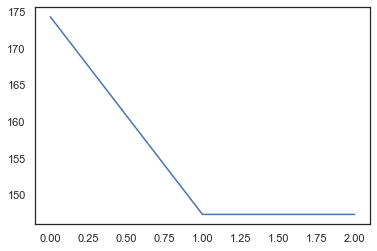

In [12]:
plt.plot(neg_lls)
plt.show()